# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Dataset

In [1]:
class Places365Train(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

    @staticmethod
    def lab_to_rgb(lab_img: torch.Tensor) -> torch.Tensor:
        return lab_img

NameError: name 'Dataset' is not defined

In [3]:
dataset = Places365Train(Path("/kaggle/input/sust-coco/kaggle/working/whole_ds"))

In [4]:
print(len(dataset))

5896


In [5]:
print(dataset[0][0].shape, dataset[0][1].shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


Showing 16 samples from training set torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


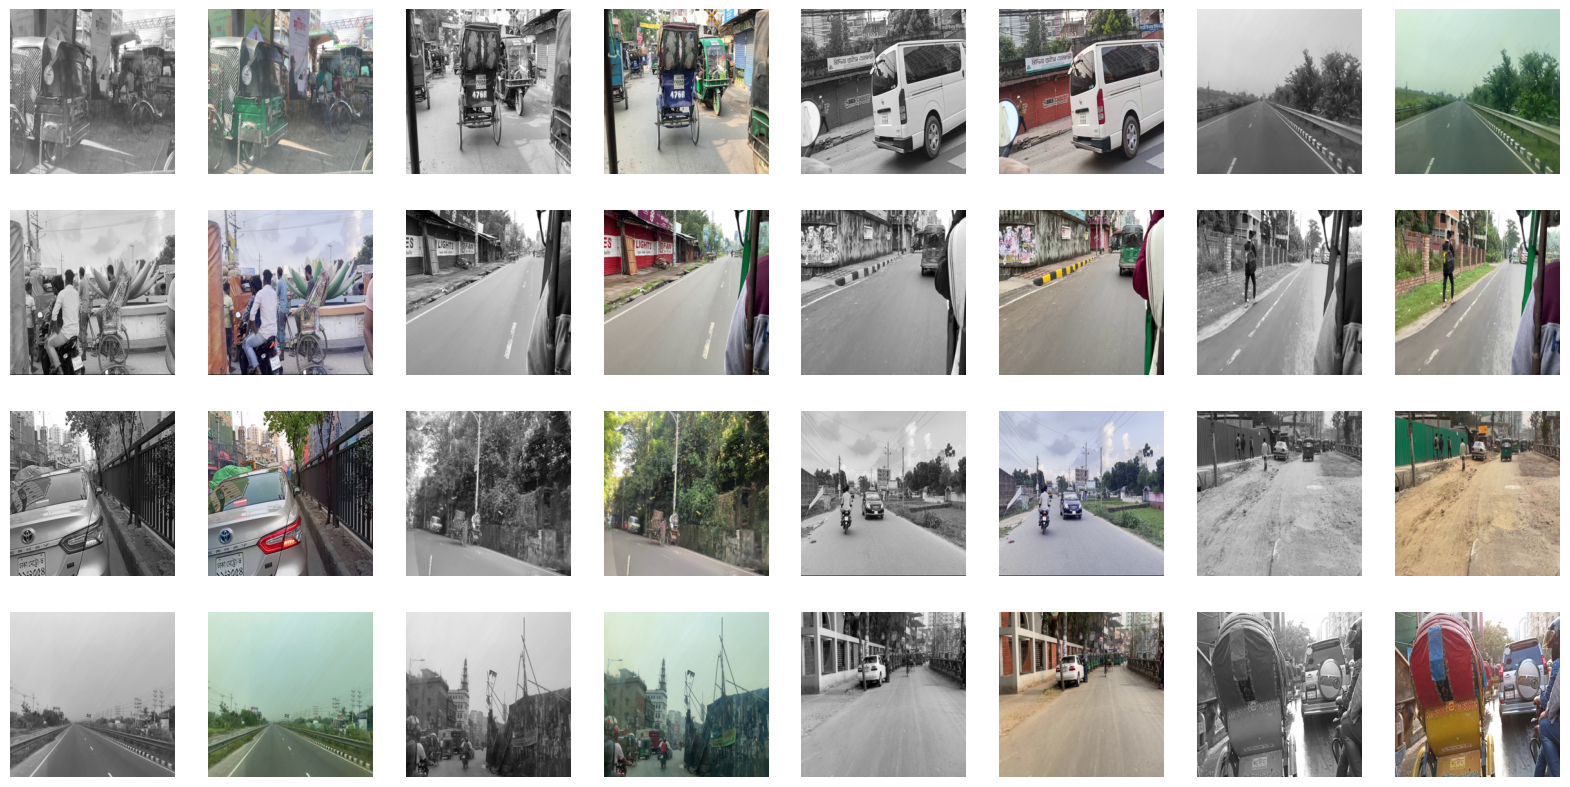

In [6]:
import matplotlib.pyplot as plt

random_sampler = RandomSampler(dataset, num_samples=16)
random_loader = DataLoader(dataset, batch_size=16, sampler=random_sampler)
plt.figure(figsize=(20, 10))
for x, y in random_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(x[i].permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(Places365Train.lab_to_rgb(y[i]).permute(1, 2, 0))
        plt.axis("off")

# Base Model

In [7]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [8]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8

        out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
        out += feature640
        out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
        out += feature224
        out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
        out += feature80
        out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
        out += feature48
        out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
        out += feature32
        out = self.colorization_layers[7:10](
            out
        )  # 32x256x256 -> 64x256x256 -> 2x256x256

        return out

    def convert_output_to_rgb(
        self, x: torch.Tensor, output: torch.Tensor
    ) -> torch.Tensor:
        return output

In [15]:
model = ConvNetWithEfficientNetFeatureExtractor().to("cuda")

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 146MB/s]


In [16]:
input = dataset[0][0].unsqueeze(0).to("cuda")
print(input.shape)

torch.Size([1, 3, 256, 256])


In [17]:
output = model(input)
output.shape

torch.Size([1, 3, 256, 256])

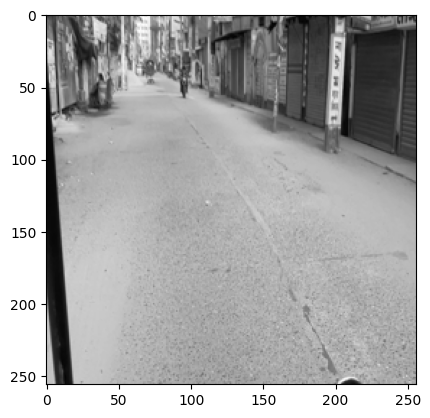

In [18]:
plt.imshow(input[0].permute(1, 2, 0).cpu())

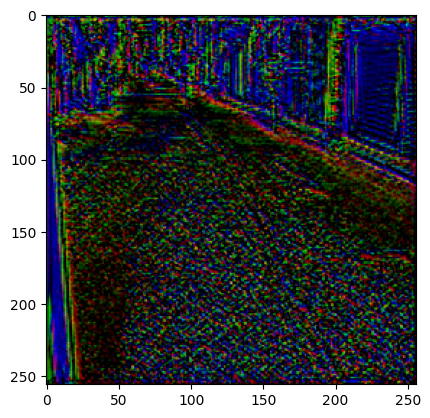

In [19]:
output_img = model.convert_output_to_rgb(input[0].cpu(), output.detach()[0].cpu())
plt.imshow(output_img.permute(1, 2, 0))

# Perceptual Loss Model

In [9]:
import torchvision.models as models

# Load the pre-trained VGG11 model
vgg11 = models.vgg11(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 177MB/s]


In [11]:
vgg11 = vgg11.features  # Only need the feature extractor

In [12]:
from torch.nn import MSELoss

criterion = MSELoss()

In [13]:
for param in vgg11.parameters():
    param.requires_grad = False

In [14]:
i1 = torch.randn((3, 224, 224))
i1.requires_grad = True

v1 = vgg11(i1)
v2 = vgg11(torch.randn((3, 224, 224)))

criterion(v1, v2)

tensor(0.0138, grad_fn=<MseLossBackward0>)

In [23]:
vgg11 = vgg11.to("cuda")

# Train With Perceptual Loss

In [20]:
from torch.optim import AdamW
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = MSELoss()

In [21]:
torch.cuda.empty_cache()

In [22]:
train_loader, val_loader = train_test_split(dataset, test_size=0.1, random_state=42)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=64, shuffle=False)

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y) + criterion(vgg11(output), vgg11(y))

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        #         train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
        #             val_loss /= len(val_loader)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

In [25]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 1/100, Train Loss: 14.3829, Val Loss: 0.5999


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 2/100, Train Loss: 5.1212, Val Loss: 0.2554


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 3/100, Train Loss: 3.8753, Val Loss: 0.1400


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 4/100, Train Loss: 3.4280, Val Loss: 0.0986


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 5/100, Train Loss: 3.2139, Val Loss: 0.0724


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 6/100, Train Loss: 3.0802, Val Loss: 0.0753


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 7/100, Train Loss: 3.0105, Val Loss: 0.0639


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 8/100, Train Loss: 2.9065, Val Loss: 0.0614


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 9/100, Train Loss: 2.7977, Val Loss: 0.0461


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 10/100, Train Loss: 2.7981, Val Loss: 0.0415


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 11/100, Train Loss: 2.7177, Val Loss: 0.0367


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 12/100, Train Loss: 2.6353, Val Loss: 0.0335


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 13/100, Train Loss: 2.6109, Val Loss: 0.0337


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 14/100, Train Loss: 2.5600, Val Loss: 0.0318


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 15/100, Train Loss: 2.5094, Val Loss: 0.0319


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 16/100, Train Loss: 2.4772, Val Loss: 0.0340


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 17/100, Train Loss: 2.4521, Val Loss: 0.0313


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 18/100, Train Loss: 2.3960, Val Loss: 0.0305


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 19/100, Train Loss: 2.3747, Val Loss: 0.0325


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 20/100, Train Loss: 2.3539, Val Loss: 0.0306


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 21/100, Train Loss: 2.3075, Val Loss: 0.0316


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 22/100, Train Loss: 2.3119, Val Loss: 0.0295


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 23/100, Train Loss: 2.2241, Val Loss: 0.0307


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 24/100, Train Loss: 2.2102, Val Loss: 0.0301


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 25/100, Train Loss: 2.1813, Val Loss: 0.0290


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 26/100, Train Loss: 2.1453, Val Loss: 0.0294


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 27/100, Train Loss: 2.1413, Val Loss: 0.0295


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 28/100, Train Loss: 2.1004, Val Loss: 0.0281


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 29/100, Train Loss: 2.1072, Val Loss: 0.0295


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 30/100, Train Loss: 2.0710, Val Loss: 0.0288


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 31/100, Train Loss: 2.0700, Val Loss: 0.0281


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 32/100, Train Loss: 2.0347, Val Loss: 0.0288


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 33/100, Train Loss: 2.0382, Val Loss: 0.0277


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 34/100, Train Loss: 1.9787, Val Loss: 0.0284


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 35/100, Train Loss: 2.0155, Val Loss: 0.0282


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 36/100, Train Loss: 1.9840, Val Loss: 0.0281


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 37/100, Train Loss: 1.9586, Val Loss: 0.0274


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 38/100, Train Loss: 1.9542, Val Loss: 0.0270


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 39/100, Train Loss: 1.9258, Val Loss: 0.0279


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 40/100, Train Loss: 1.9231, Val Loss: 0.0269


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 41/100, Train Loss: 1.9172, Val Loss: 0.0283


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 42/100, Train Loss: 1.9000, Val Loss: 0.0273


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 43/100, Train Loss: 1.8704, Val Loss: 0.0299


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 44/100, Train Loss: 1.8891, Val Loss: 0.0272


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 45/100, Train Loss: 1.8861, Val Loss: 0.0271


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 46/100, Train Loss: 1.8575, Val Loss: 0.0269


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 47/100, Train Loss: 1.8321, Val Loss: 0.0270


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 48/100, Train Loss: 1.8240, Val Loss: 0.0255


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 49/100, Train Loss: 1.7954, Val Loss: 0.0258


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 50/100, Train Loss: 1.8214, Val Loss: 0.0273


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 51/100, Train Loss: 1.8141, Val Loss: 0.0263


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 52/100, Train Loss: 1.8075, Val Loss: 0.0260


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 53/100, Train Loss: 1.7674, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 54/100, Train Loss: 1.7602, Val Loss: 0.0257


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 55/100, Train Loss: 1.7767, Val Loss: 0.0266


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 56/100, Train Loss: 1.7308, Val Loss: 0.0260


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 57/100, Train Loss: 1.7660, Val Loss: 0.0259


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 58/100, Train Loss: 1.7216, Val Loss: 0.0252


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 59/100, Train Loss: 1.7325, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 60/100, Train Loss: 1.7074, Val Loss: 0.0266


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 61/100, Train Loss: 1.7342, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 62/100, Train Loss: 1.7236, Val Loss: 0.0266


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 63/100, Train Loss: 1.7042, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 64/100, Train Loss: 1.7019, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 65/100, Train Loss: 1.6898, Val Loss: 0.0261


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 66/100, Train Loss: 1.7218, Val Loss: 0.0251


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 67/100, Train Loss: 1.6719, Val Loss: 0.0251


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 68/100, Train Loss: 1.6792, Val Loss: 0.0266


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 69/100, Train Loss: 1.6874, Val Loss: 0.0269


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch 70/100, Train Loss: 1.6694, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 71/100, Train Loss: 1.6775, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 72/100, Train Loss: 1.6506, Val Loss: 0.0262


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 73/100, Train Loss: 1.6443, Val Loss: 0.0275


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 74/100, Train Loss: 1.6482, Val Loss: 0.0262


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 75/100, Train Loss: 1.6314, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 76/100, Train Loss: 1.6391, Val Loss: 0.0249


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 77/100, Train Loss: 1.6513, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 78/100, Train Loss: 1.6264, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 79/100, Train Loss: 1.6146, Val Loss: 0.0251


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 80/100, Train Loss: 1.6304, Val Loss: 0.0265


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 81/100, Train Loss: 1.6227, Val Loss: 0.0258


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 82/100, Train Loss: 1.6218, Val Loss: 0.0250


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 83/100, Train Loss: 1.5947, Val Loss: 0.0255


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 84/100, Train Loss: 1.6040, Val Loss: 0.0243


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 85/100, Train Loss: 1.6064, Val Loss: 0.0246


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 86/100, Train Loss: 1.5741, Val Loss: 0.0243


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 87/100, Train Loss: 1.5877, Val Loss: 0.0246


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 88/100, Train Loss: 1.6133, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 89/100, Train Loss: 1.5947, Val Loss: 0.0250


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 90/100, Train Loss: 1.5844, Val Loss: 0.0244


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 91/100, Train Loss: 1.6016, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 92/100, Train Loss: 1.5862, Val Loss: 0.0246


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 93/100, Train Loss: 1.5797, Val Loss: 0.0253


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 94/100, Train Loss: 1.5798, Val Loss: 0.0246


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 95/100, Train Loss: 1.5638, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 96/100, Train Loss: 1.5642, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 97/100, Train Loss: 1.5986, Val Loss: 0.0244


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 98/100, Train Loss: 1.5693, Val Loss: 0.0257


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 99/100, Train Loss: 1.5679, Val Loss: 0.0243


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Epoch 100/100, Train Loss: 1.5595, Val Loss: 0.0244


In [26]:
torch.save(model.state_dict(), "model.pth")

# Inference

In [27]:
model.load_state_dict(torch.load("/home/salkhon/repo/colorization/models/model.pth"))

torch.Size([3, 256, 256])


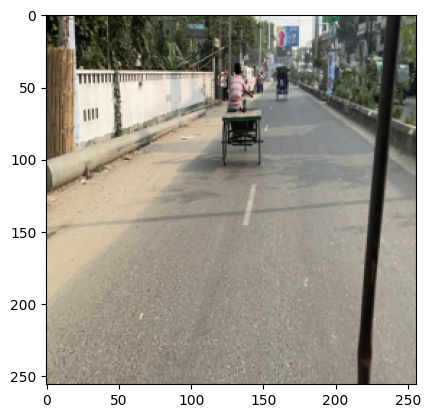

In [28]:
input = dataset[100][1].to("cuda")
print(input.shape)
plt.imshow(dataset.lab_to_rgb(input).permute(1, 2, 0).cpu())

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


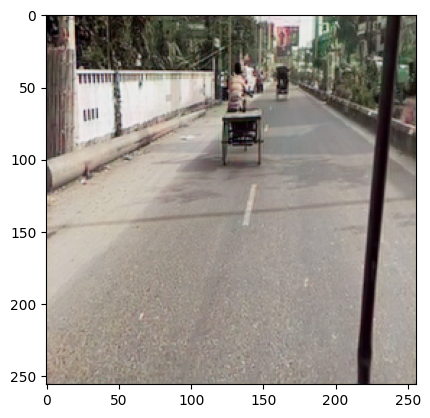

In [29]:
input = dataset[100][0].to("cuda").unsqueeze(0)
output = model(input)
print(output.shape)

output_img = dataset.lab_to_rgb(output.detach()[0].cpu())
print(output_img.shape)
plt.imshow(output_img.permute(1, 2, 0))

Showing 16 samples from training set torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


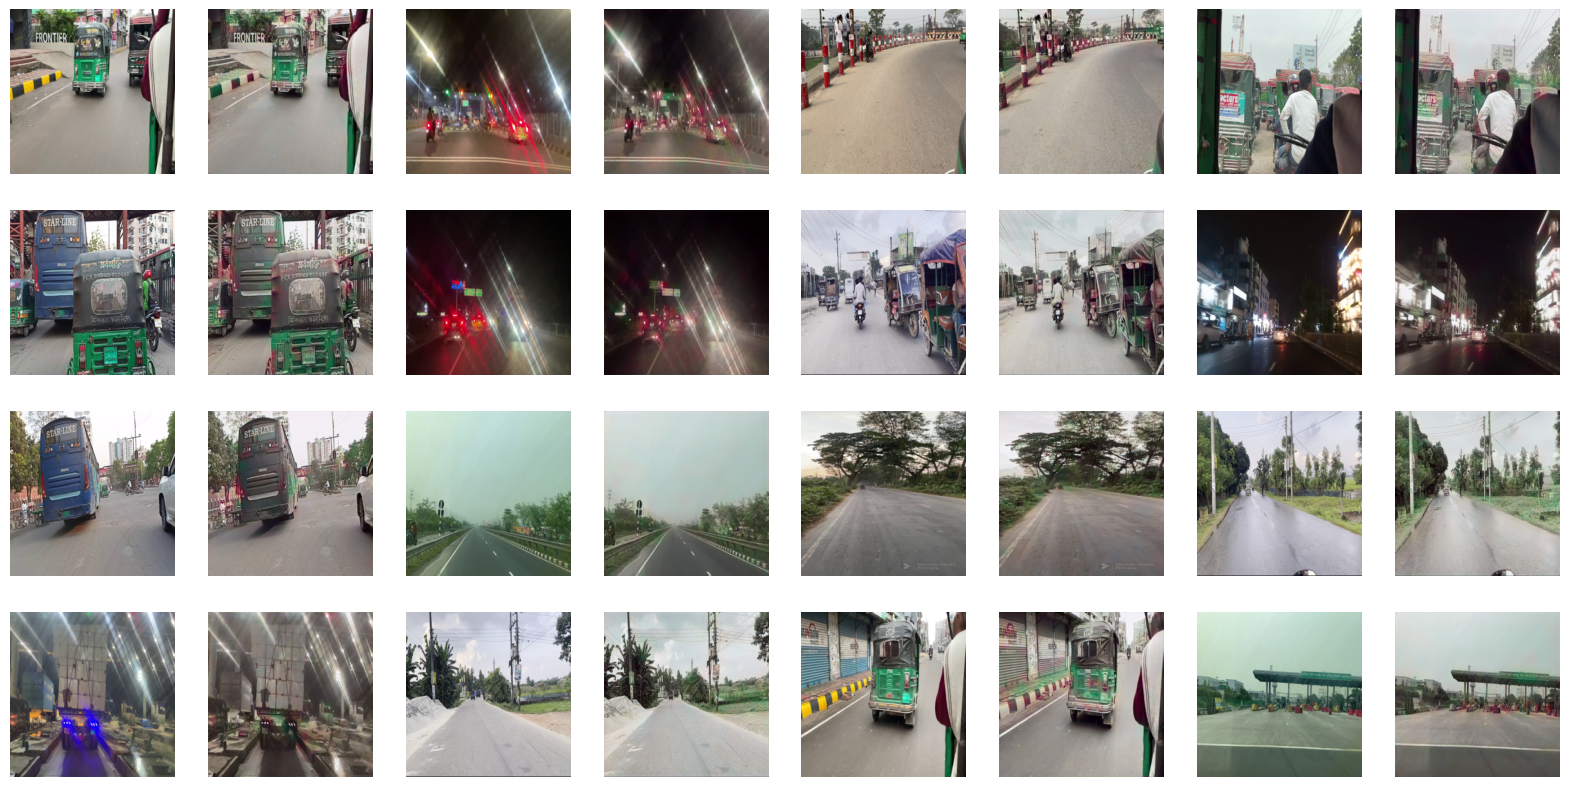

In [30]:
random_sampler = RandomSampler(dataset, num_samples=16)
random_loader = DataLoader(dataset, batch_size=16, sampler=random_sampler)
plt.figure(figsize=(20, 10))
for x, y in random_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(Places365Train.lab_to_rgb(y[i]).permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)

        input_ = x[i].to("cuda").unsqueeze(0)
        output = model(input_)
        output_img = model.convert_output_to_rgb(
            input_[0].cpu(), output.detach()[0].cpu()
        )
        plt.imshow(output_img.permute(1, 2, 0))
        plt.axis("off")